In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [214]:
def getRandomGraphAdjacencyMatrix(nNodes, maxDistance, probability):
    # Return random integers from low (inclusive) to high (exclusive).
    randomMatrix = np.random.randint(1, maxDistance, (nNodes, nNodes))
    
    for i in range(0, len(randomMatrix)):
        # Diagonal to 0
        randomMatrix[i, i] = 0
        # Diagonal symmetric
        for j in range(i + 1, len(randomMatrix)):
            # remove edges to avoid complete graph
            if random.random() > probability:
                randomMatrix[j, i] = randomMatrix[i, j]
            else:
                randomMatrix[j, i] = randomMatrix[i, j] = 0

    return randomMatrix

# Example execution
adjacencyMatrix = getRandomGraphAdjacencyMatrix(8, 50, 0.5)
print(adjacencyMatrix)

# Example 1
#adjacencyMatrixExample1 = [
#    [ 0  0  0  1  0  0  3  0]
#    [ 0  0  0 31 48  0  0  0]
#    [ 0  0  0  0  0  0  0  5]
#    [ 1 31  0  0  0  0  0 40]
#    [ 0 48  0  0  0 24  0  0]
#    [ 0  0  0  0 24  0  1  0]
#    [ 3  0  0  0  0  1  0 17]
#    [ 0  0  5 40  0  0 17  0]
#]

[[ 0 20 29 20  0  0  0  3]
 [20  0 38  0  0 30  0 37]
 [29 38  0  0 46  0  3  0]
 [20  0  0  0 37  2  4  0]
 [ 0  0 46 37  0  0  5  0]
 [ 0 30  0  2  0  0  0  0]
 [ 0  0  3  4  5  0  0  0]
 [ 3 37  0  0  0  0  0  0]]


Nodes of graph: 
[0, 1, 2, 3, 4, 5, 6, 7]
Edges of graph: 
[(0, 1), (0, 2), (0, 3), (0, 7), (1, 2), (1, 5), (1, 7), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (4, 6)]


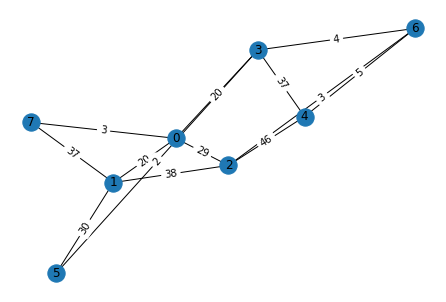

In [215]:
def printGraph(adjacencyMatrix):
    G=nx.Graph()
    
    for i in range(0, len(adjacencyMatrix)):
        G.add_node(i)
    
    for idx, x in np.ndenumerate(adjacencyMatrix):
        if x > 0:
            G.add_edge(*idx, weight=x)
        
    print("Nodes of graph: ")
    print(G.nodes())
    print("Edges of graph: ")
    print(G.edges())
    
    pos = nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    #plt.savefig("simple_path.png") # save as png

# Example execution
printGraph(adjacencyMatrix)

In [216]:
def dijkstra(adjacencyMatrix, fromNode):
    # (distance, previousNode)
    path = np.full((len(adjacencyMatrix), 2), -1)
    
    priorityQueue = []
    # (distance, previousNode, currentNode)
    priorityQueue.append((0, fromNode, fromNode))
    
    while len(priorityQueue):
        current = priorityQueue.pop(0)
        if path[current[2], 1] == -1 or path[current[2], 0] > current[0]:
            path[current[2]] = [current[0], current[1]] 
            for idx, x in enumerate(adjacencyMatrix[current[2]]):
                if x > 0:
                    distance = current[0] + x
                    if path[idx, 1] == -1 or path[idx, 0] > distance:
                        priorityQueue.append((distance, current[2], idx))
        priorityQueue.sort()

    return path
    
# Example execution
print(dijkstra(adjacencyMatrix, 0))

[[ 0  0]
 [20  0]
 [27  6]
 [20  0]
 [29  6]
 [22  3]
 [24  3]
 [ 3  0]]


In [217]:
def getCPD(adjacencyMatrix):
    cpd = np.zeros(adjacencyMatrix.shape, dtype=int)
    
    for x in range(0, len(adjacencyMatrix)):
        # get previous node column as array after calculate dijkstra
        cpd[x] = dijkstra(adjacencyMatrix, x)[:,1]
    
    for i in range(0, len(cpd)):
        # Diagonal to -1 as dont cares
        cpd[i, i] = -1
    
    # rows is destination and column is start point
    # so to know first step from 0 to 5 it is cpd[5, 0]
    # to change to original format need transpose
    return np.transpose(cpd)

# Example execution
cpd = getCPD(adjacencyMatrix)
print(cpd)

[[-1  1  3  3  3  3  3  7]
 [ 0 -1  2  5  5  5  5  0]
 [ 6  1 -1  6  6  6  6  6]
 [ 0  5  6 -1  6  5  6  0]
 [ 6  6  6  6 -1  6  6  6]
 [ 3  1  3  3  3 -1  3  3]
 [ 3  3  2  3  4  3 -1  3]
 [ 0  0  0  0  0  0  0 -1]]


In [218]:
def getRLE(cpd):
    cpdcopy = np.copy(cpd)
    rle = []
    
    for i in cpdcopy:
        for j in range(1, len(i)):
            if i[j] == -1:
                i[j] = i[j - 1]
        for j in range(0, len(i) - 1):
            if i[j] == -1:
                i[j] = i[j + 1]
    for i in cpdcopy:
        rl = []
        rl.append((1, i[0]))
        for j in range(1, len(i)):
            # -1 as dont cares
            if i[j] != i[j - 1]:
                rl.append((j + 1, i[j]))
        rle.append(rl)
    return rle

# Example execution        
rle = getRLE(cpd)
for r in rle:
    print(r)

[(1, 1), (3, 3), (8, 7)]
[(1, 0), (3, 2), (4, 5), (8, 0)]
[(1, 6), (2, 1), (4, 6)]
[(1, 0), (2, 5), (3, 6), (6, 5), (7, 6), (8, 0)]
[(1, 6)]
[(1, 3), (2, 1), (3, 3)]
[(1, 3), (3, 2), (4, 3), (5, 4), (6, 3)]
[(1, 0)]


In [219]:
def getRLELength(rle):
    return sum(map(lambda x : len(x), rle))
    
# Example execution
print(getRLELength(rle))

26


In [220]:
def getWildcardsCPD(cpd, wildcards):
    wildcardCPD = np.copy(cpd)
    
    for i in reversed(range(0, len(wildcards))):
        for j in range(0, i):
            wildcardCPD[wildcards[i], wildcards[j]] = -1
            
    return wildcardCPD

# Example execution
wildcards = np.arange(len(cpd)).tolist()
random.shuffle(wildcards)
wildcardCPD = getWildcardsCPD(cpd, wildcards)
print(wildcardCPD)

[[-1 -1  3 -1  3  3 -1  7]
 [ 0 -1  2  5  5  5  5  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0 -1  6 -1  6  5  6  0]
 [-1 -1  6 -1 -1 -1 -1 -1]
 [-1 -1  3 -1  3 -1 -1 -1]
 [ 3 -1  2 -1  4  3 -1  3]
 [-1 -1  0 -1  0  0 -1 -1]]


In [221]:
# Need to implement another for rows
def getPermutationCPD(cpd, permutation):
    return cpd[:, permutation]
    
# Example execution 
print(cpd)
perm = np.arange(len(cpd)).tolist()
random.shuffle(perm)
permutationCPD = getPermutationCPD(cpd, perm)
print(permutationCPD)

[[-1  1  3  3  3  3  3  7]
 [ 0 -1  2  5  5  5  5  0]
 [ 6  1 -1  6  6  6  6  6]
 [ 0  5  6 -1  6  5  6  0]
 [ 6  6  6  6 -1  6  6  6]
 [ 3  1  3  3  3 -1  3  3]
 [ 3  3  2  3  4  3 -1  3]
 [ 0  0  0  0  0  0  0 -1]]
[[ 7  3  3  1  3  3 -1  3]
 [ 0  5  5 -1  5  2  0  5]
 [ 6  6  6  1  6 -1  6  6]
 [ 0  6  5  5 -1  6  0  6]
 [ 6 -1  6  6  6  6  6  6]
 [ 3  3 -1  1  3  3  3  3]
 [ 3  4  3  3  3  2  3 -1]
 [-1  0  0  0  0  0  0  0]]


In [226]:
wildcards = np.arange(len(cpd)).tolist()

wildcardCPD = getWildcardsCPD(cpd, wildcards)
rle = getRLE(wildcardCPD)
rleLength = getRLELength(rle)
maxLength = rleLength
print(wildcards, maxLength)
print(wildcardCPD)
wildcardCPDNext = wildcardCPD
for x in rle:
    print(x)

for i in range(0, 100):
    random.shuffle(wildcards)
    
    wildcardCPD = getWildcardsCPD(cpd, wildcards)
    rle = getRLE(wildcardCPD)
    rleLength = getRLELength(rle)
    if rleLength < maxLength:
        maxLength = rleLength
        wildcardCPDNext = wildcardCPD
        print("--------------------------------------")
        print(wildcards, maxLength)
        print(wildcardCPD)
        for x in rle:
            print(x)

[0, 1, 2, 3, 4, 5, 6, 7] 21
[[-1  1  3  3  3  3  3  7]
 [-1 -1  2  5  5  5  5  0]
 [-1 -1 -1  6  6  6  6  6]
 [-1 -1 -1 -1  6  5  6  0]
 [-1 -1 -1 -1 -1  6  6  6]
 [-1 -1 -1 -1 -1 -1  3  3]
 [-1 -1 -1 -1 -1 -1 -1  3]
 [-1 -1 -1 -1 -1 -1 -1 -1]]
[(1, 1), (3, 3), (8, 7)]
[(1, -1), (2, 2), (4, 5), (8, 0)]
[(1, -1), (3, 6)]
[(1, -1), (4, 6), (6, 5), (7, 6), (8, 0)]
[(1, -1), (5, 6)]
[(1, -1), (6, 3)]
[(1, -1), (7, 3)]
[(1, -1)]
--------------------------------------
[1, 2, 5, 3, 6, 7, 4, 0] 15
[[-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0 -1  2  5  5  5  5  0]
 [ 6 -1 -1  6  6  6  6  6]
 [ 0 -1 -1 -1  6 -1  6  0]
 [ 6 -1 -1 -1 -1 -1 -1 -1]
 [ 3 -1 -1  3  3 -1  3  3]
 [ 3 -1 -1 -1  4 -1 -1  3]
 [ 0 -1 -1 -1  0 -1 -1 -1]]
[(1, -1)]
[(1, 0), (3, 2), (4, 5), (8, 0)]
[(1, 6)]
[(1, 0), (5, 6), (8, 0)]
[(1, 6)]
[(1, 3)]
[(1, 3), (5, 4), (8, 3)]
[(1, 0)]
--------------------------------------
[4, 2, 5, 7, 6, 0, 1, 3] 14
[[-1  1 -1  3 -1 -1 -1 -1]
 [-1 -1 -1  5 -1 -1 -1 -1]
 [ 6  1 -1  6 -1  6  6  6]
 [-1 -1 -1 

In [227]:
perm = np.arange(len(cpd)).tolist()

permutationCPD = getPermutationCPD(wildcardCPDNext, perm)
rle = getRLE(permutationCPD)
rleLength = getRLELength(rle)
maxLength = rleLength
print(perm, maxLength)
print(permutationCPD)
for x in rle:
    print(x)

for i in range(0, 100):
    random.shuffle(perm)
    
    permutationCPD = getPermutationCPD(wildcardCPDNext, perm)
    rle = getRLE(permutationCPD)
    rleLength = getRLELength(rle)
    if rleLength < maxLength:
        maxLength = rleLength
        print("--------------------------------------")
        print(perm, maxLength)
        print(permutationCPD)
        for x in rle:
            print(x)

[0, 1, 2, 3, 4, 5, 6, 7] 13
[[-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0 -1  2  5 -1  5  5  0]
 [ 6 -1 -1  6 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1 -1 -1]
 [ 6  6  6  6 -1  6  6  6]
 [ 3 -1  3  3 -1 -1  3  3]
 [ 3 -1  2  3 -1 -1 -1 -1]
 [ 0 -1  0  0 -1 -1  0 -1]]
[(1, -1)]
[(1, 0), (3, 2), (4, 5), (8, 0)]
[(1, 6)]
[(1, 0)]
[(1, 6)]
[(1, 3)]
[(1, 3), (3, 2), (4, 3)]
[(1, 0)]
--------------------------------------
[7, 0, 4, 6, 3, 1, 2, 5] 12
[[-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0 -1  5  5 -1  2  5]
 [-1  6 -1 -1  6 -1 -1 -1]
 [-1  0 -1 -1 -1 -1 -1 -1]
 [ 6  6 -1  6  6  6  6  6]
 [ 3  3 -1  3  3 -1  3 -1]
 [-1  3 -1 -1  3 -1  2 -1]
 [-1  0 -1  0  0 -1  0 -1]]
[(1, -1)]
[(1, 0), (4, 5), (7, 2), (8, 5)]
[(1, 6)]
[(1, 0)]
[(1, 6)]
[(1, 3)]
[(1, 3), (7, 2)]
[(1, 0)]
--------------------------------------
[0, 7, 6, 4, 5, 3, 1, 2] 11
[[-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  5 -1  5  5 -1  2]
 [ 6 -1 -1 -1 -1  6 -1 -1]
 [ 0 -1 -1 -1 -1 -1 -1 -1]
 [ 6  6  6 -1  6  6  6  6]
 [ 3  3  3 -1 -1  3 -1  3]
 [ 3 -1 -1 -1 -1  3 -1  